## هیستوگرام گرادیان‌های جهت‌دار (HOGs)

- HOGها یک توصیف‌گر ویژگی هستند که به طور گسترده و موفقیت‌آمیزی برای شناسایی اشیاء استفاده شده‌اند.

- این روش اشیاء را به صورت یک بردار ویژگی منفرد نمایش می‌دهد، برخلاف روش‌هایی که هر بخش از تصویر را با یک بردار ویژگی جداگانه نمایش می‌دهند.

- این ویژگی با استفاده از یک پنجره لغزان روی تصویر محاسبه می‌شود، به طوری که یک توصیف‌گر HOG برای هر موقعیت مانند SIFT محاسبه می‌شود و مقیاس تصویر نیز تنظیم می‌شود (هرم‌بندی).

- HOGها اغلب همراه با طبقه‌بندهای SVM (ماشین بردار پشتیبان) استفاده می‌شوند؛ هر توصیف‌گر HOG محاسبه‌شده به یک طبقه‌بند SVM داده می‌شود تا مشخص شود که شیء مورد نظر پیدا شده است یا خیر.

## Histogram of gradients (HOGs) step by step

1. تصویر به سلول‌هایی با اندازه ۸x۸ پیکسل تقسیم می‌شود (معمولاً با رنگ سبز نمایش داده می‌شود).
2. برای هر پیکسل در سلول، گرادیان (جهت و بزرگی) محاسبه می‌شود.
3. مجموعاً ۶۴ گرادیان (۸x۸) به دست می‌آید که با استفاده از یک هیستوگرام جهت‌گیری خلاصه می‌شوند.
4. هیستوگرام جهت‌گیری به ۹ بازه زاویه‌ای بین ۰ تا ۱۸۰ درجه تقسیم می‌شود (هر بازه ۲۰ درجه، مطابق مقاله دالال و تریگز).
5. در نتیجه، اطلاعات ۶۴ گرادیان به ۹ مقدار هیستوگرام کاهش می‌یابد.
6. سپس گرادیان‌ها را نرمال‌سازی می‌کنیم تا ویژگی‌ها نسبت به تغییرات روشنایی و کنتراست (مانند تغییرات نور و روشنایی تصویر) مقاوم شوند. به عنوان مثال، اگر بردارها را بر بزرگی گرادیان تقسیم کنیم، مقدار نرمال‌شده برای همه برابر ۰.۷۰۷ خواهد بود. این نرمال‌سازی باعث می‌شود ویژگی‌ها نسبت به تغییرات نور محیط حساس نباشند.
7. به جای نرمال‌سازی سلول‌ها به صورت جداگانه، روشی به نام «نرمال‌سازی بلوکی» استفاده می‌شود. در این روش، چند سلول مجاور به صورت یک بلوک در نظر گرفته می‌شوند و نرمال‌سازی روی کل بلوک انجام می‌شود. این کار باعث می‌شود ویژگی‌ها نسبت به تغییرات محلی تصویر نیز مقاوم‌تر شوند.


## Histogram of Oriented Gradients

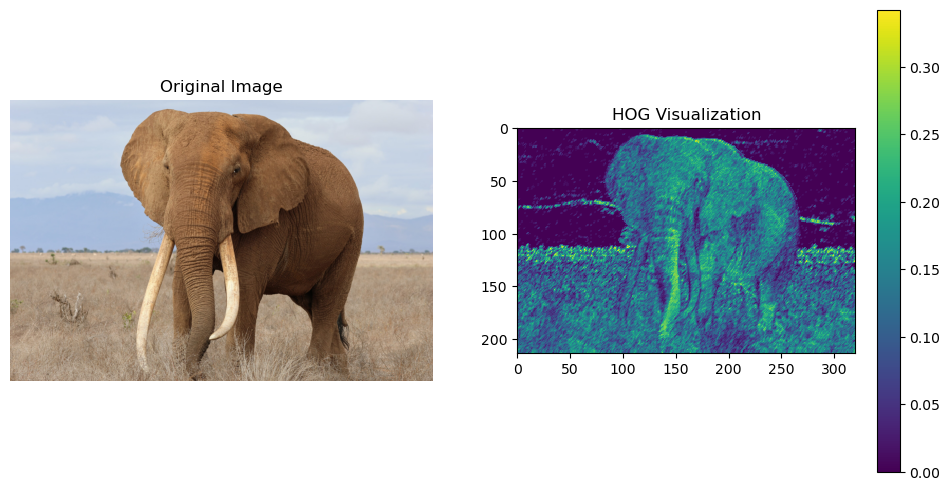

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load image then grayscale
image = cv2.imread('images/elephant.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# h x w in pixels
cell_size = (8, 8) 

 # h x w in cells
block_size = (2, 2) 

# number of orientation bins
nbins = 9

# Using OpenCV's HOG Descriptor
# winSize is the size of the image cropped to a multiple of the cell size
hog = cv2.HOGDescriptor(_winSize=(gray.shape[1] // cell_size[1] * cell_size[1],
                                  gray.shape[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)

# Create numpy array shape which we use to create hog_feats
n_cells = (gray.shape[0] // cell_size[0], gray.shape[1] // cell_size[1])

# We index blocks by rows first.
# hog_feats now contains the gradient amplitudes for each direction,
# for each cell of its group for each group. Indexing is by rows then columns.
hog_feats = hog.compute(gray).reshape(n_cells[1] - block_size[1] + 1,
                        n_cells[0] - block_size[0] + 1,
                        block_size[0], block_size[1], nbins).transpose((1, 0, 2, 3, 4))  

# Create our gradients array with nbin dimensions to store gradient orientations 
gradients = np.zeros((n_cells[0], n_cells[1], nbins))

# Create array of dimensions 
cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

# Block Normalization
for off_y in range(block_size[0]):
    for off_x in range(block_size[1]):
        gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                  off_x:n_cells[1] - block_size[1] + off_x + 1] += \
            hog_feats[:, :, off_y, off_x, :]
        cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                   off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

# Average gradients
gradients /= cell_count

# Plot HOGs using Matplotlib with original image
color_bins = 5
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Show original image in first subplot
axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[0].axis('off')

# Show HOG visualization in second subplot
c = axs[1].pcolor(gradients[:, :, color_bins])
axs[1].invert_yaxis()
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_title('HOG Visualization')
fig.colorbar(c, ax=axs[1])
plt.show()

cv2.destroyAllWindows()

این کد استخراج ویژگی‌های HOG (Histogram of Oriented Gradients) از یک تصویر را با استفاده از OpenCV و نمایش آن با Matplotlib انجام می‌دهد. توضیح هر بخش به صورت گام‌به‌گام:

1. **وارد کردن کتابخانه‌ها**  
    کتابخانه‌های مورد نیاز (`numpy`، `cv2` و `matplotlib.pyplot`) وارد می‌شوند.

2. **خواندن و تبدیل تصویر به سطح خاکستری**  
    تصویر با دستور `cv2.imread` خوانده شده و سپس به تصویر خاکستری تبدیل می‌شود تا پردازش ساده‌تر شود.

3. **تعریف پارامترهای HOG**  
    - `cell_size`: اندازه هر سلول (۸x۸ پیکسل)
    - `block_size`: اندازه هر بلوک (۲x۲ سلول)
    - `nbins`: تعداد سطل‌های جهت‌گیری (۹ جهت)

4. **ایجاد شیء HOGDescriptor**  
    با توجه به اندازه تصویر و پارامترهای بالا، شیء HOG ساخته می‌شود.

5. **محاسبه تعداد سلول‌ها**  
    تعداد سلول‌ها در هر بعد تصویر محاسبه می‌شود.

6. **محاسبه ویژگی‌های HOG**  
    ویژگی‌های HOG با استفاده از تابع `hog.compute` محاسبه و به شکل مناسب بازآرایی می‌شوند تا برای هر بلوک و سلول قابل دسترسی باشند.

7. **ایجاد آرایه برای گرادیان‌ها و شمارش سلول‌ها**  
    آرایه‌ای برای ذخیره مجموع گرادیان‌ها و آرایه‌ای برای شمارش تعداد دفعات حضور هر سلول در بلوک‌ها ساخته می‌شود.

8. **نرمال‌سازی بلوکی**  
    با پیمایش هر بلوک، گرادیان‌های هر سلول جمع و شمارش می‌شوند تا در نهایت میانگین گرفته شود (نرمال‌سازی).

9. **نمایش تصویر و ویژگی‌های HOG**  
    - تصویر اصلی در یک subplot نمایش داده می‌شود.
    - ویژگی‌های HOG (برای یکی از جهت‌ها) با استفاده از `pcolor` به صورت تصویری نمایش داده می‌شود.
    - یک colorbar نیز برای نمایش شدت‌ها اضافه می‌شود.

این کد به شما کمک می‌کند تا نحوه استخراج و نمایش ویژگی‌های HOG را به صورت عملی مشاهده کنید.
